In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"piyush2798","key":"9d2fadeec97b96b64f836c4e2a0ed507"}'}

In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:

!kaggle datasets download -d biaiscience/dogs-vs-cats 

 99% 805M/814M [00:07<00:00, 27.2MB/s]
100% 814M/814M [00:07<00:00, 112MB/s] 


In [0]:
!unzip -q -n dogs-vs-cats.zip

In [0]:
! unzip -q -n test.zip
!unzip -q -n train.zip

In [0]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from PIL import Image

In [0]:


data_dir = "train"



In [0]:


class myDataset(torch.utils.data.Dataset):
    def __init__(self, prefix, files, transform, img_loader):
        self.imgs = files
        self.transform = transform
        self.loader = img_loader
        self.prefix = prefix
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = 0 if 'cat' in img else 1
        img = self.loader(f"{self.prefix}/{img}")
        return self.transform(img), label



In [0]:
import os

img_train, img_test = train_test_split(os.listdir(data_dir), test_size=0.1, random_state=42)



In [0]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [0]:
train_data = myDataset(data_dir, img_train, transform, lambda file: Image.open(file).convert('RGB'))
test_data = myDataset(data_dir, img_test, transform, lambda file: Image.open(file).convert('RGB'))


In [0]:


train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64)



In [0]:


x_exp, y_exp = next(iter(test_data_loader))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


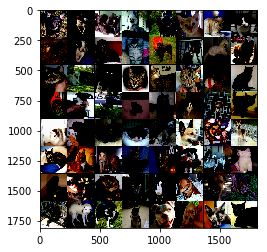

In [0]:
img = torchvision.utils.make_grid(x_exp)
img = img.numpy().transpose([1,2,0])
plt.imshow(img)
plt.show()


In [0]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 96256259.38it/s]


In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for parma in model.parameters():
    parma.requires_grad = False

In [0]:


model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 2)
)



In [0]:


if torch.cuda.is_available():
    model = model.cuda()

In [0]:


loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)



In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
epoch_n = 5
time_s = time.time()

for epoch in range(epoch_n):
    print(f"Epoch {epoch+1}/{epoch_n}")
    print("-"*10)
    
    for phase in ["train", "valid"]:
        if phase == 'train':
            print("Training...")
            model.train(True)
            dataloader = train_data_loader
            img_datasets = train_data
        else:
            print("Validing...")
            model.eval()
            dataloader = test_data_loader
            img_datasets = test_data
        
        running_loss = 0.0
        running_acc = 0.0
        
        for batch, data in tqdm(enumerate(dataloader, 1), total=len(dataloader)):
            X, y = data
            X, y = Variable(X.cuda()), Variable(y.cuda())
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
    
            optimizer.zero_grad()
            batch_loss = loss(y_pred, y)

            if phase == "train":
                batch_loss.backward()
                optimizer.step()
            
            running_loss += batch_loss.data
            running_acc += torch.sum(pred == y.data)
            
            if batch%100 == 0 and phase == "train":
                print(f"Batch {batch}, Train Loss {running_loss/(batch):.4f}, Train Acc {100*running_acc/(64*(batch))}")
        
        epoch_loss = running_loss*64/len(img_datasets)
        epoch_acc = 100*running_acc/(len(img_datasets) + 0.0)
        
        print(f"{phase} Loss {epoch_loss:.4f} Acc {epoch_acc:.4f}")
time_e = time.time()
print(f"Spend {(time_e-time_s)/60:.3f} mins")


Epoch 1/5
----------
Training...


Batch 100, Train Loss 0.1709, Train Acc 94
Batch 200, Train Loss 0.1130, Train Acc 96
Batch 300, Train Loss 0.0926, Train Acc 96

train Loss 0.0865 Acc 97.0000
Validing...



valid Loss 0.0372 Acc 98.0000
Epoch 2/5
----------
Training...


Batch 100, Train Loss 0.0260, Train Acc 99
Batch 200, Train Loss 0.0296, Train Acc 99
Batch 300, Train Loss 0.0305, Train Acc 99

train Loss 0.0298 Acc 99.0000
Validing...



valid Loss 0.0364 Acc 98.0000
Epoch 3/5
----------
Training...


Batch 100, Train Loss 0.0135, Train Acc 99
Batch 200, Train Loss 0.0126, Train Acc 99
Batch 300, Train Loss 0.0139, Train Acc 99

train Loss 0.0147 Acc 99.0000
Validing...



valid Loss 0.0412 Acc 98.0000
Epoch 4/5
----------
Training...


Batch 100, Train Loss 0.0058, Train Acc 99
Batch 200, Train Loss 0.0069, Train Acc 99
Batch 300, Train Loss 0.0073, Train Acc 99

train Loss 0.0074 Acc 99.0000
Validing...



valid Loss 0.0459 Acc 98.0000
Epoch 5/5
----------
Training...


Batch 100, Train Loss 0.0028, Train Acc 99
Batch 200, Train Loss 0.0036, Train Acc 99
Batch 300, Train Loss 0.0036, Train Acc 99

train Loss 0.0035 Acc 99.0000
Validing...



valid Loss 0.0477 Acc 98.0000
Spend 19.941 mins


In [0]:
torch.save(model, './transfer_vgg16.pth')